## Градиентный бустинг 
### Ноутбук составлен по мотивам лекций профессора Воронцова по ML для МФТИ и ШАД, а также по презентации Tanqi Chen Introduction to boosted trees

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
from mlxtend.plotting import plot_decision_regions

Оставим класс узла дерева из предыдущих ноутбуков. Он не поменяется

In [2]:
class Node:
    def __init__(self, left = None, right = None, value = None, feature = None, feature_val = None):
        self.__left = left
        self.__right = right
        self.__feature = feature
        self.__value = value
        self.__feature_val = feature_val
        
    @property
    def right(self):
        return self.__right
    
    @right.setter
    def right(self, right):
        if isinstance(right, Node):
            self.__right = right
        else:
            print("self.__right can only be an instance of Node")
            
    @property
    def left(self):
        return self.__left
    
    @left.setter
    def left(self, left):
        if isinstance(left, Node):
            self.__left = left
        else:
            print("self.__left can only be an instance of Node")
            
    @property
    def value(self):
        return self.__value
    
    @property
    def feature(self):
        return self.__feature
    
    @property
    def feature_val(self):
        return self.__feature_val

Логика прохода по дереву также не должна измениться:

In [3]:
def DT(root, test_obj):
    node = root
    while node.value is None:
        if test_obj[node.feature] <= node.feature_val:
            node = node.left
        else:
            node = node.right
    return node.value

Реализуем алгоритм градиентного бустинга. Создадим тестовый датасет на 4 признака, как и для Random Forest

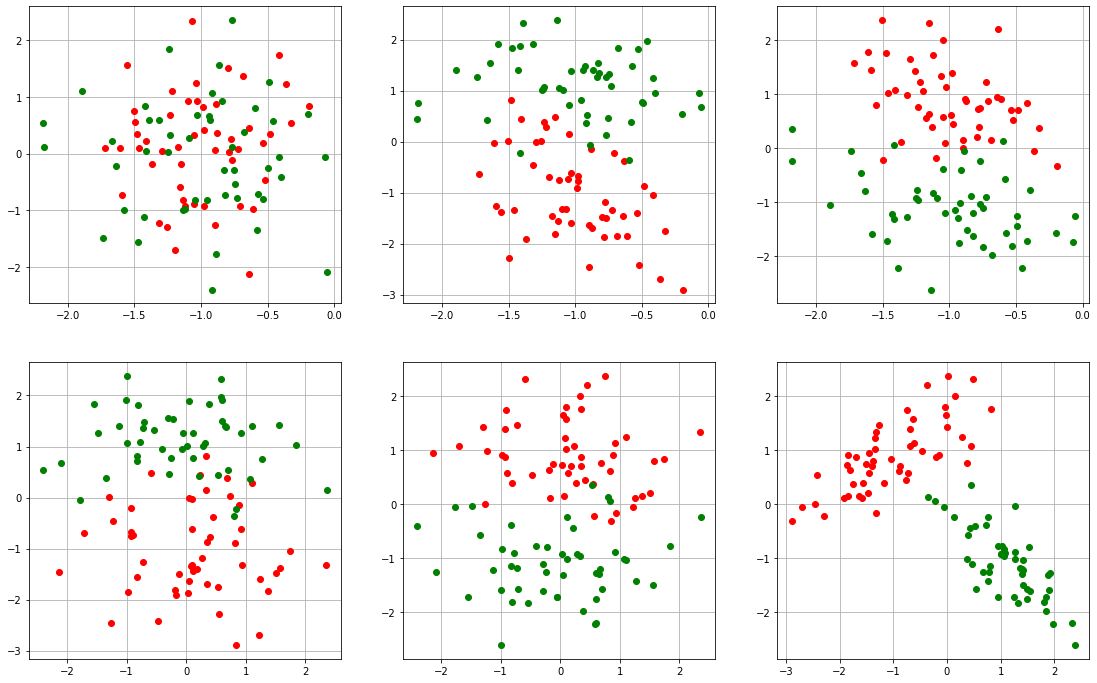

In [4]:
X, Y = make_classification(n_samples=150, n_features=4, 
                           n_informative=3, n_classes=2, 
                           n_redundant=0,
                           n_clusters_per_class=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=50)

fig, gs = plt.figure(figsize=(19, 12)), gridspec.GridSpec(2, 3)

ax = []
for i in range(6):
    ax.append(fig.add_subplot(gs[i]))

ax[0].plot(X_train[np.where(Y_train==0), 0], X_train[np.where(Y_train==0), 1], 'ro')
ax[0].plot(X_train[np.where(Y_train==1), 0], X_train[np.where(Y_train==1), 1], 'go')
ax[0].grid()

ax[1].plot(X_train[np.where(Y_train==0), 0], X_train[np.where(Y_train==0), 2], 'ro')
ax[1].plot(X_train[np.where(Y_train==1), 0], X_train[np.where(Y_train==1), 2], 'go')
ax[1].grid()

ax[2].plot(X_train[np.where(Y_train==0), 0], X_train[np.where(Y_train==0), 3], 'ro')
ax[2].plot(X_train[np.where(Y_train==1), 0], X_train[np.where(Y_train==1), 3], 'go')
ax[2].grid()

ax[3].plot(X_train[np.where(Y_train==0), 1], X_train[np.where(Y_train==0), 2], 'ro')
ax[3].plot(X_train[np.where(Y_train==1), 1], X_train[np.where(Y_train==1), 2], 'go')

ax[3].grid()

ax[4].plot(X_train[np.where(Y_train==0), 1], X_train[np.where(Y_train==0), 3], 'ro')
ax[4].plot(X_train[np.where(Y_train==1), 1], X_train[np.where(Y_train==1), 3], 'go')
ax[4].plot(X_train[np.where(Y_train==2), 1], X_train[np.where(Y_train==2), 3], 'bo')
ax[4].grid()

ax[5].plot(X_train[np.where(Y_train==0), 2], X_train[np.where(Y_train==0), 3], 'ro')
ax[5].plot(X_train[np.where(Y_train==1), 2], X_train[np.where(Y_train==1), 3], 'go')
ax[5].plot(X_train[np.where(Y_train==2), 2], X_train[np.where(Y_train==2), 3], 'bo')
ax[5].grid()

plt.show()

Что понадобится для алгоритма: для перебора признаков деревьев и выбора наилучшего сплита, как и в ID3, необходимо реализовать критерий поиска оптимальной структуры. Для этого нужно задаться функцией потерь, посчитать от нее первую и вторую производную от выхода классификатора на предыдущем шаге, и, далее, посчитать целевую функцию. 
Для простоты возьмем сначала квадратичную функцию потерь, после можно будет попробовать NLLLoss.

Как выглядит целевая функция для поиска оптимального дерева:

### $$ Obj = -\frac{1}{2}\sum_{j=1}^T(\frac{G_j^2}{H_j + \lambda}) + \gamma T,$$
где T - число листьев в дереве,

$\gamma$ - параметр, регулирующий наказание за сложность дерева с точки зрения количества листов,

$\lambda$ - параметр, регулирующий наказание за сложность дерева по сумме L2-норм весов в листах дерева,

#### $G_i = \sum_{i \in I_j}{g_i}$, $H_i = \sum_{i \in I_j}{h_i}$ - 
суммы первых и вторых производных от функции потерь

#### $g_i = \frac{\partial l(y_i, \hat{y_i}^{(t-1)})}{\partial \hat{y_i}^{(t-1)}}$, $h_i = \frac{\partial^2 l(y_i, \hat{y_i}^{(t-1)})}{\partial{\hat{y_i}^{(t-1)}}^2}$,
которые рассчитываются для каждого элемента обучающей выборки i, попадающего множество объектов $I_j$, относимого классификатором к листу j

In [5]:
def sqr1(y, y_hat):
    return y_hat - y

def sqr2(y, y_hat):
    return y - y + 1

In [6]:
def gain(xl, yl, yl_hat, xr, yr, yr_hat, gamma, lmbd, g = sqr1, h = sqr2, debug = 0):
    Gl, Hl = g(yl, yl_hat).sum(), h(yl, yl_hat).sum()
    Gr, Hr = g(yr, yr_hat).sum(), h(yr, yr_hat).sum()
    if debug == 2: print(Gl, Gr, Hl, Hr)
    result = Gl**2 / (Hl + lmbd) + Gr**2 / (Hr + lmbd) - (Gl + Gr)**2 / (Hl + Hr + lmbd) - gamma
    if debug == 2: print(result)
    return result, Gl, Hl, Gr, Hr

In [7]:
def nextNode(X_train, Y_train, Y_hat = None, min_gain = 0, gamma = 0.1, lmbd = 0.1, g = sqr1, h = sqr2, orientation = "root", level = 0, debug = 0):
    if Y_hat is None:
        Y_hat = np.zeros(Y_train.shape)
    max_gain = -1e3
    Gl_= Gr_ = Hl_ = Hr_ = None
    X_left_ = Y_left_ = Y_hat_left_ = X_right_ = Y_right_ = Y_hat_right_ = None
    feature_ = val_ = None
    
    tab = "---" * level
    for feature in range(X_train.shape[1]):
        if debug == 2: print(f"\n *** working with feature {feature} *** \n")
        order = np.argsort(X_train[:, feature])
        X_sorted, Y_sorted, Y_hat_sorted = X_train[order], Y_train[order], Y_hat[order]
        for i, val in enumerate(X_sorted[:, feature][1: -1]):
            X_left, Y_left, Y_hat_left = X_sorted[:i], Y_sorted[:i], Y_hat_sorted[:i]
            X_right, Y_right, Y_hat_right = X_sorted[i:], Y_sorted[i:], Y_hat_sorted[i:]
            curr_gain, Gl, Hl, Gr, Hr = gain(X_left, Y_left, Y_hat_left, X_right, Y_right, Y_hat_right, gamma, lmbd, g, h)
            if curr_gain > max_gain:
                max_gain = curr_gain
                Gl_, Hl_, Gr_, Hr_ = Gl, Hl, Gr, Hr
                X_left_, Y_left_, Y_hat_left_, X_right_, Y_right_, Y_hat_right_ = X_left, Y_left, Y_hat_left, X_right, Y_right, Y_hat_right
                feature_, val_ = feature, val
                if debug == 2: print("new max_gain found:", max_gain)
                if debug == 2: print(f"feature = {feature}, feature val = {val}")
                
    if max_gain < min_gain:
        G, H = g(Y_train, Y_hat).sum(), h(Y_train, Y_hat).sum()
        w = -G / (H + lmbd)
        if debug == 1: print(f"{tab} level {level}: {orientation} creating leaf node with weight {w}")
        level += 1
        return Node(value = w)
        
    wl = -Gl / (Hl + lmbd)
    wr = -Gr / (Hr + lmbd)
    if debug == 1: print(f"{tab} level {level}: {orientation} creating split with feature {feature_} val = {val_}")
    level += 1
    return Node(left = nextNode(X_left_, Y_left_, Y_hat = Y_hat_left_, min_gain = 0, gamma = 0.1, lmbd = 0.1, 
                                g = sqr1, h = sqr2, orientation = "left", level = level, debug = debug),
                right = nextNode(X_right_, Y_right_, Y_hat = Y_hat_right_, min_gain = 0, gamma = 0.1, lmbd = 0.1, 
                                 g = sqr1, h = sqr2, orientation = "right", level = level, debug = debug),
                feature  = feature_, feature_val = val_)

In [8]:
testnode = nextNode(X_train, Y_train, min_gain = 0, gamma = 0.1, lmbd = 0.1, g = sqr1, h = sqr2, debug = 1)

 level 0: root creating split with feature 3 val = -0.17459535737471055
--- level 1: left creating split with feature 2 val = 0.36891957180399826
------ level 2: left creating leaf node with weight -0.0
------ level 2: right creating leaf node with weight 0.9977324263038548
--- level 1: right creating split with feature 0 val = -1.6110776019077049
------ level 2: left creating leaf node with weight 0.9523809523809523
------ level 2: right creating split with feature 3 val = 0.14923311541229245
--------- level 3: left creating split with feature 2 val = -0.2248301153154928
------------ level 4: left creating leaf node with weight -0.0
------------ level 4: right creating leaf node with weight 0.9677419354838709
--------- level 3: right creating leaf node with weight -0.0


In [9]:
Y_hat = [1 if DT(testnode, y) > 0.5 else 0 for y in X_test]
np.where(Y_hat != Y_test)[0].shape[0]

4